# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [2]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/core already exists, skipping download
Downloaded parser, extracting to ../stanford-NLP/parser
../stanford-NLP/ner already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
Done setting up the Stanford NLP collection


We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [3]:
import lucem_illud.stanford as stanford

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [4]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [5]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [6]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [7]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1, -1) #Reindex to make things nice in the future
redditTopScores[-5:]

,author,over_18,score,subreddit,text,title,url,sentences
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [8]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [9]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [10]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 (')', 14),
 ('time', 14),
 ('lot', 12),
 ('computer', 12),
 ('life', 11),
 ('email', 11),
 ('**Genius**', 10),
 ('**Me**', 9),
 ('message', 9),
 ('system', 9),
 ('day', 9),
 ('story', 8),
 ('office', 8),
 ('part', 8),
 ('laptop', 8),
 ('today', 8),
 ('call', 8),
 ('user', 7)]

What about the number of top verbs (`VB`)?

In [11]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('send', 6),
 ('tell', 6),
 ('help', 6),
 ('look', 6),
 ('go', 5),
 ('take', 4),
 ('call', 4),
 ('feel', 4),
 ('thank', 4),
 ('open', 4),
 ('use', 4),
 ('receive', 4)]

What about the adjectives that modify the word, "computer"?

In [12]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [13]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [14]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [15]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [16]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

I collected the plot summaries of sci-fi movies in the year 2008 and 2009 available on IMDb and try to perform the POS tagging on a subset of it.

In [45]:
plots_ori = pandas.read_csv('scifi_uncoded.csv')
plots = plots_ori[:50]
plots[:5]

,movie_id,title,year,plot
0,3280625,'O puorco,2009,The sacrifice of pig in some ancient ethnic gr...
1,3281971,00:05'01,2008,"A scenic work about nature, human nature, and ..."
2,3288302,20 Years After,2008,Everything that could go wrong did go wrong: W...
3,3289227,2012,2009,Geophysicist Adrian Helmsley officially visits...
4,3289786,2081,2009,A short film adaptation of Kurt Vonnegut's Har...


In [46]:
plots['sentences'] = plots['plot'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
plots[:5]

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,movie_id,title,year,plot,sentences
0,3280625,'O puorco,2009,The sacrifice of pig in some ancient ethnic gr...,"[[The, sacrifice, of, pig, in, some, ancient, ..."
1,3281971,00:05'01,2008,"A scenic work about nature, human nature, and ...","[[A, scenic, work, about, nature, ,, human, na..."
2,3288302,20 Years After,2008,Everything that could go wrong did go wrong: W...,"[[Everything, that, could, go, wrong, did, go,..."
3,3289227,2012,2009,Geophysicist Adrian Helmsley officially visits...,"[[Geophysicist, Adrian, Helmsley, officially, ..."
4,3289786,2081,2009,A short film adaptation of Kurt Vonnegut's Har...,"[[A, short, film, adaptation, of, Kurt, Vonneg..."


In [47]:
plots['POS_sents'] = plots['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))
plots[:5]

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,movie_id,title,year,plot,sentences,POS_sents
0,3280625,'O puorco,2009,The sacrifice of pig in some ancient ethnic gr...,"[[The, sacrifice, of, pig, in, some, ancient, ...","[[(The, DT), (sacrifice, NN), (of, IN), (pig, ..."
1,3281971,00:05'01,2008,"A scenic work about nature, human nature, and ...","[[A, scenic, work, about, nature, ,, human, na...","[[(A, DT), (scenic, JJ), (work, NN), (about, I..."
2,3288302,20 Years After,2008,Everything that could go wrong did go wrong: W...,"[[Everything, that, could, go, wrong, did, go,...","[[(Everything, NN), (that, WDT), (could, MD), ..."
3,3289227,2012,2009,Geophysicist Adrian Helmsley officially visits...,"[[Geophysicist, Adrian, Helmsley, officially, ...","[[(Geophysicist, NNP), (Adrian, NNP), (Helmsle..."
4,3289786,2081,2009,A short film adaptation of Kurt Vonnegut's Har...,"[[A, short, film, adaptation, of, Kurt, Vonneg...","[[(A, DT), (short, JJ), (film, NN), (adaptatio..."


In [48]:
# A function to list POS and sort them by count
def list_pos(df, countTarget):
    targetCounts = {}
    for entry in df['POS_sents']:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != countTarget:
                    continue
                elif ent in targetCounts:
                    targetCounts[ent] += 1
                else:
                    targetCounts[ent] = 1
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedTargets

In [49]:
# Count the number of nouns
list_pos(plots, 'NN')[:20]

[('life', 18),
 ('man', 15),
 ('world', 15),
 ('time', 10),
 ('woman', 9),
 ('way', 7),
 ('story', 6),
 ('government', 6),
 ('father', 6),
 ('future', 6),
 ('love', 6),
 ('journey', 6),
 ('film', 6),
 ('night', 5),
 ('day', 5),
 ('businessman', 5),
 ('mission', 5),
 ('battle', 5),
 ('place', 4),
 ('machine', 4)]

In [50]:
# Count the number of verbs
list_pos(plots, 'VB')[:20]

[('be', 15),
 ('find', 9),
 ('save', 6),
 ('take', 4),
 ('leave', 4),
 ('go', 4),
 ('have', 3),
 ('stop', 3),
 ('survive', 3),
 ('discover', 3),
 ('heal', 2),
 ('convince', 2),
 ('destroy', 2),
 ('die', 2),
 ('come', 2),
 ('understand', 2),
 ('do', 2),
 ('end', 2),
 ('bring', 2),
 ('question', 2)]

In [51]:
# Count the number of adjectives
list_pos(plots, 'JJ')[:20]

[('human', 9),
 ('own', 8),
 ('young', 7),
 ('new', 7),
 ('native', 6),
 ('other', 5),
 ('local', 4),
 ('first', 4),
 ('powerful', 4),
 ('old', 4),
 ('mysterious', 4),
 ('last', 4),
 ('same', 3),
 ('wealthy', 3),
 ('only', 3),
 ('ordinary', 3),
 ('alien', 3),
 ('single', 3),
 ('short', 3),
 ('futuristic', 3)]

In [52]:
# Count the number of adverbs
list_pos(plots, 'RB')[:20]

[('only', 10),
 ('not', 7),
 ('soon', 6),
 ('also', 5),
 ("n't", 5),
 ('just', 5),
 ('Now', 5),
 ('once', 4),
 ('somewhere', 4),
 ('alone', 3),
 ('Meanwhile', 3),
 ('now', 3),
 ('back', 3),
 ('again', 3),
 ('quickly', 3),
 ('Not', 2),
 ('about', 2),
 ('long', 2),
 ('too', 2),
 ('immediately', 2)]

In [53]:
# A function to find POS associated with words of interest
def find_surrounding_pos(df, Word, NTarget):
    NResults = set()
    for entry in df['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1,ent2.lower())==(NTarget,Word):
                    NResults.add(ent1)
                else:
                    continue
    return NResults

In [60]:
find_surrounding_pos(plots, 'woman', 'JJ')

{'native', 'old', 'young'}

In [61]:
find_surrounding_pos(plots, 'man', 'JJ')

{'elderly', 'grieving', 'ordinary', 'same'}

In [62]:
find_surrounding_pos(plots, 'world', 'JJ')

{'distant', 'entire', 'neo-realistic'}

In [66]:
find_surrounding_pos(plots, 'life',  'JJ')

{'entire', 'horrible', 'human', 'innocent', 'mundane', 'own'}

In [67]:
find_surrounding_pos(plots, 'time',  'JJ')

{'first', 'same'}

In [77]:
find_surrounding_pos(plots, 'future',  'JJ')

{'apocalyptic', 'dystopian', 'not-so-distant', 'unknown'}

In [76]:
find_surrounding_pos(plots, 'government',  'JJ')

{'brutal'}

In [109]:
find_surrounding_pos(plots, 'find',  'PRP')

{'they'}

In [116]:
find_surrounding_pos(plots, 'discover',  'PRP')

{'they'}

Sci-fi films are usually about the future, world, space, technology, life and surviving. 

It is interesting to observe that in our sample plots, the "government" is also appearing often, and as a "brutal" one. As we can recall, in most films, the government does play a negative role, and the officers from the government are usually stupid, while the main character would be depicted as someone opposite or at least irrelevant to the government.  It seems that in our sample plots, the government is even described worse than the average.

“Future" in our sample plots is "apocalyptic" and "unknown", and “life” is “horrible”, “mundane”, and “innocent”, and the actions appearing often are “find”, “save”, ”leave”, “survive”, which aligns with the nature of sci-fi film stories that some people fight for something catastrophic in a future setting for the survival of human beings.

I didn’t find much meaningful conditional frequencies due to the limited data size. It would be more interesting to further investigate it if I can include more plot summaries and compare them in pre-great-recession, during-great-recession and post-great-recession period, to see if the films in different periods of great recession are catering to different needs of people, if any.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [117]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [118]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [119]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [120]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or those occurring only twice:

In [124]:
[x[0] for x in sortedEntities if x[1] == 2][:10]

['small',
 'others',
 'soon',
 'fix',
 'lunch',
 'absolutely',
 'LOWERCASE',
 'brought',
 'Fail',
 'Everyone']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [122]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('GOOGLE', 1),
 ('Clickity', 1),
 ('Buzzfeed', 1),
 ('UK', 1),
 ('CMD', 1),
 ('Reddit', 1)]

What about the Organizations?

In [125]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Google', 6), ('CMD', 1), ('Citrix', 1), ('GOOGLE', 1), ('Helpdesk', 1)]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged. What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

In [126]:
plots['classified_sents'] = plots['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))
plots['classified_sents'][:10]

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0    [[(The, O), (sacrifice, O), (of, O), (pig, O),...
1    [[(A, O), (scenic, O), (work, O), (about, O), ...
2    [[(Everything, O), (that, O), (could, O), (go,...
3    [[(Geophysicist, O), (Adrian, PERSON), (Helmsl...
4    [[(A, O), (short, O), (film, O), (adaptation, ...
5    [[(Not, O), (much, O), (left, O), (since, O), ...
6    [[(The, O), (film, O), (27, O), (Down, O), (is...
7    [[(Los, LOCATION), (Angeles, LOCATION), (,, O)...
8    [[(In, O), (a, O), (world, O), (destroyed, O),...
9    [[(It, O), (is, O), (the, O), (year, O), (3032...
Name: classified_sents, dtype: object

In [129]:
# Find all tags
kinds = set()
for entry in plots['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            kinds.add(kind)
kinds

{'LOCATION', 'O', 'ORGANIZATION', 'PERSON'}

In [130]:
# A function to find entities with different tags
def find_entities(df, tag):
    Counts = {}
    for entry in df['classified_sents']:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != tag:
                    continue
                elif ent in Counts:
                    Counts[ent] += 1
                else:
                    Counts[ent] = 1
    sortedCounts = sorted(Counts.items(), key = lambda x: x[1], reverse = True)
    return sortedCounts

In [132]:
find_entities(plots, 'O')[:10]

[('the', 283),
 (',', 224),
 ('.', 207),
 ('a', 149),
 ('to', 138),
 ('and', 137),
 ('of', 125),
 ('is', 76),
 ('in', 75),
 ('his', 49)]

In [133]:
find_entities(plots, 'LOCATION')

[('Earth', 8),
 ('City', 3),
 ('Angeles', 2),
 ('California', 2),
 ('Los', 2),
 ('States', 2),
 ('New', 2),
 ('Metro', 2),
 ('United', 2),
 ('Arizona', 2),
 ('Alliance', 1),
 ('Ghota', 1),
 ('India', 1),
 ('World', 1),
 ('Mojave', 1),
 ('Istanbul', 1),
 ('US', 1),
 ('Landing', 1),
 ('Canada', 1),
 ('Honolulu', 1),
 ('Chicago', 1),
 ('Johannesburg', 1),
 ('Desert', 1),
 ('Buck', 1),
 ('Lake', 1),
 ('Hawaii', 1),
 ('Scarlet', 1),
 ('Boston', 1),
 ('Italy', 1),
 ('Maine', 1),
 ('Michigan', 1),
 ('Creek', 1),
 ('York', 1)]

In [134]:
find_entities(plots, 'ORGANIZATION')

[('Colonials', 2),
 ('Laurel', 2),
 ('Earth', 1),
 ('Police', 1),
 ('Enlightenment', 1),
 ('Station', 1),
 ('Beauty', 1),
 ('Southern', 1),
 ('Justice', 1),
 ('Miller', 1),
 ('Richard', 1),
 ('Space', 1),
 ('Corridor', 1),
 ('Church', 1),
 ('Systems', 1),
 ('Elysian', 1),
 ('Boston', 1),
 ('University', 1),
 ('Program', 1),
 ('United', 1)]

In [137]:
find_entities(plots, 'PERSON')

[('Ariel', 10),
 ('Allison', 7),
 ('Liz', 5),
 ('Oliver', 5),
 ('Tammy', 4),
 ('Sarah', 4),
 ('Khalia', 4),
 ('Jake', 4),
 ('Remy', 3),
 ('Archie', 3),
 ('Cameron', 3),
 ('Nicholas', 3),
 ('Justin', 3),
 ('Madison', 3),
 ('Strider', 3),
 ('Thomason', 3),
 ('Michael', 3),
 ('Lewis', 3),
 ('Jennifer', 2),
 ('Kalia', 2),
 ('Andy', 2),
 ('Stuart', 2),
 ('Nick', 2),
 ('Marcus', 2),
 ('Tom', 2),
 ('Benny', 2),
 ('John', 2),
 ('Pearson', 2),
 ('Jonathan', 2),
 ('Toby', 2),
 ('Pandora', 2),
 ('Crenshaw', 2),
 ('Julius', 2),
 ('Neal', 2),
 ('Linda', 2),
 ('Pentupp', 2),
 ('Brandon', 2),
 ('Burke', 2),
 ('Lana', 2),
 ('Johnson', 2),
 ('Joe', 2),
 ('Michelle', 2),
 ('Vonnegut', 1),
 ('Sully', 1),
 ('Ted', 1),
 ('Natasha', 1),
 ('Maya', 1),
 ('Armie', 1),
 ('Cosmo', 1),
 ('Dillman', 1),
 ('Harrison', 1),
 ('Gabriel', 1),
 ('Apollo', 1),
 ('Holt', 1),
 ('Clarkson', 1),
 ('Hammer', 1),
 ('Julie', 1),
 ('Rose', 1),
 ('Hagerty', 1),
 ('Bergeron', 1),
 ('Bob', 1),
 ('Mackey', 1),
 ('Commodore', 1),
 ('

It seems that most of our movies are set in American cities but there are still "India", "Istanbul", "Itaty" appearing in Location entities. "Earth" and "world" appear multiple times, and despite the big cities, "Desert" and deserts or islands such as "Mojave" and "Honolulu" appear, which makes sense as the sci-fi movies are usually about space exploration and spaceships are usually launched in remote and humanless areas. The most frequent organization entity "Colonials" indicates some stories with aliens or robots. The most frequent names seems to be female names, though due to the limited data, I'm hesitated to draw any conclusion.

In [163]:
# Subset the first five plots and store the automated tag of entities into a dataframe
auto_codings = pandas.DataFrame()
for entry in plots['classified_sents'][:5]:
    for sentence in entry:
        for ent, kind in sentence:
            auto_codings = auto_codings.append([(ent, kind)], ignore_index = True)
auto_codings = auto_codings.rename(columns={0: "ent", 1: "kind"})
auto_codings[:10]

,ent,kind
0,The,O
1,sacrifice,O
2,of,O
3,pig,O
4,in,O
5,some,O
6,ancient,O
7,ethnic,O
8,group,O
9,from,O


In [169]:
# Save the auto codings
auto_codings.to_csv('auto_codings.csv', index = False)

In [170]:
# Read the hand codings
hand_codings = pandas.read_csv('hand_codings.csv')
hand_codings[:10]

,ent,kind,hand_code
0,The,O,O
1,sacrifice,O,O
2,of,O,O
3,pig,O,O
4,in,O,O
5,some,O,O
6,ancient,O,O
7,ethnic,O,O
8,group,O,O
9,from,O,O


In [193]:
import sklearn
print('LOCATION:')
print('Precision:', sklearn.metrics.precision_score(hand_codings['hand_code'], hand_codings['kind'], labels = ['LOCATION'], average = 'micro')) #precision
print('Recall:', sklearn.metrics.recall_score(hand_codings['kind'], hand_codings['hand_code'], labels = ['LOCATION'], average = 'micro')) #recall
print('F-1 measure:', sklearn.metrics.f1_score(hand_codings['kind'], hand_codings['hand_code'], labels = ['LOCATION'], average = 'micro')) #F-1 measure

LOCATION:
Precision: 0.875
Recall: 0.875
F-1 measure: 0.7368421052631579


In [194]:
print('ORGANIZATION:')
print('Precision:', sklearn.metrics.precision_score(hand_codings['hand_code'], hand_codings['kind'], labels = ['ORGANIZATION'], average = 'micro')) #precision
print('Recall:', sklearn.metrics.recall_score(hand_codings['kind'], hand_codings['hand_code'], labels = ['ORGANIZATION'], average = 'micro')) #recall
print('F-1 measure:', sklearn.metrics.f1_score(hand_codings['kind'], hand_codings['hand_code'], labels = ['ORGANIZATION'], average = 'micro')) #F-1 measure

ORGANIZATION:
Precision: 0.0
Recall: 0.0
F-1 measure: 0.0


In [195]:
print('PERSON:')
print('Precision:', sklearn.metrics.precision_score(hand_codings['hand_code'], hand_codings['kind'], labels = ['PERSON'], average = 'micro')) #precision
print('Recall:', sklearn.metrics.recall_score(hand_codings['kind'], hand_codings['hand_code'], labels = ['PERSON'], average = 'micro')) #recall
print('F-1 measure:', sklearn.metrics.f1_score(hand_codings['kind'], hand_codings['hand_code'], labels = ['PERSON'], average = 'micro')) #F-1 measure

PERSON:
Precision: 1.0
Recall: 1.0
F-1 measure: 0.9473684210526316


# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [196]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are interested in is the relationship between different types of speech

In [197]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [198]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [199]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [200]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

{'shot'}

Or if we want to to look at the whole tree

In [201]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [202]:
list(parses[1])[0].pretty_print()

                     ROOT                           
                      |                              
                      S                             
       _______________|___________________________   
      |                          VP               | 
      |                __________|___             |  
      |               |              PP           | 
      |               |      ________|___         |  
      NP              |     |            NP       | 
  ____|__________     |     |     _______|____    |  
 DT   JJ    JJ   NN  VBD    IN   DT      JJ   NN  . 
 |    |     |    |    |     |    |       |    |   |  
The quick brown fox jumped over the     lazy dog  . 



## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here](http://universaldependencies.org/u/overview/syntax.html). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [203]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x113b162f0>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
                 'word

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

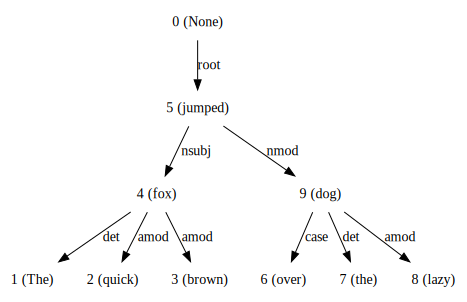

In [205]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

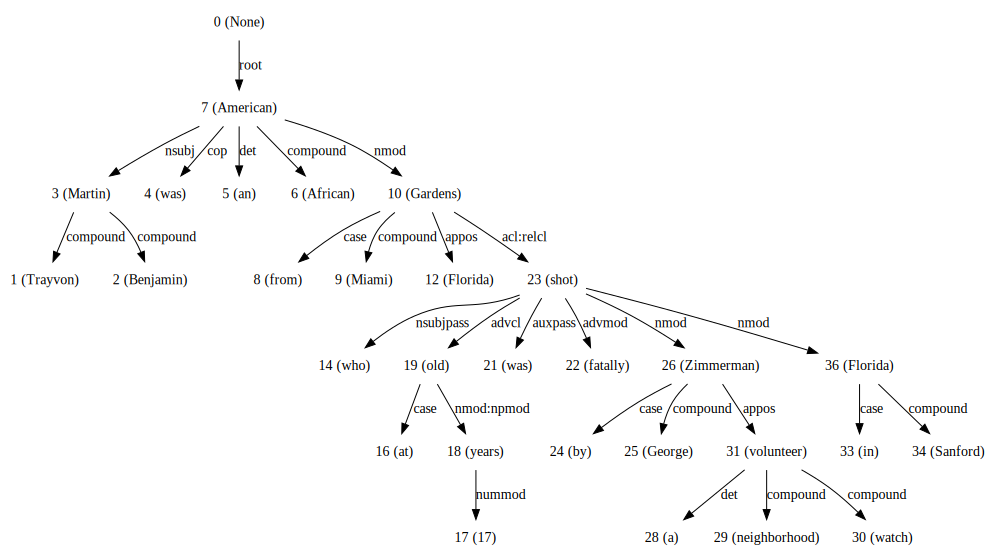

In [206]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [207]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [208]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

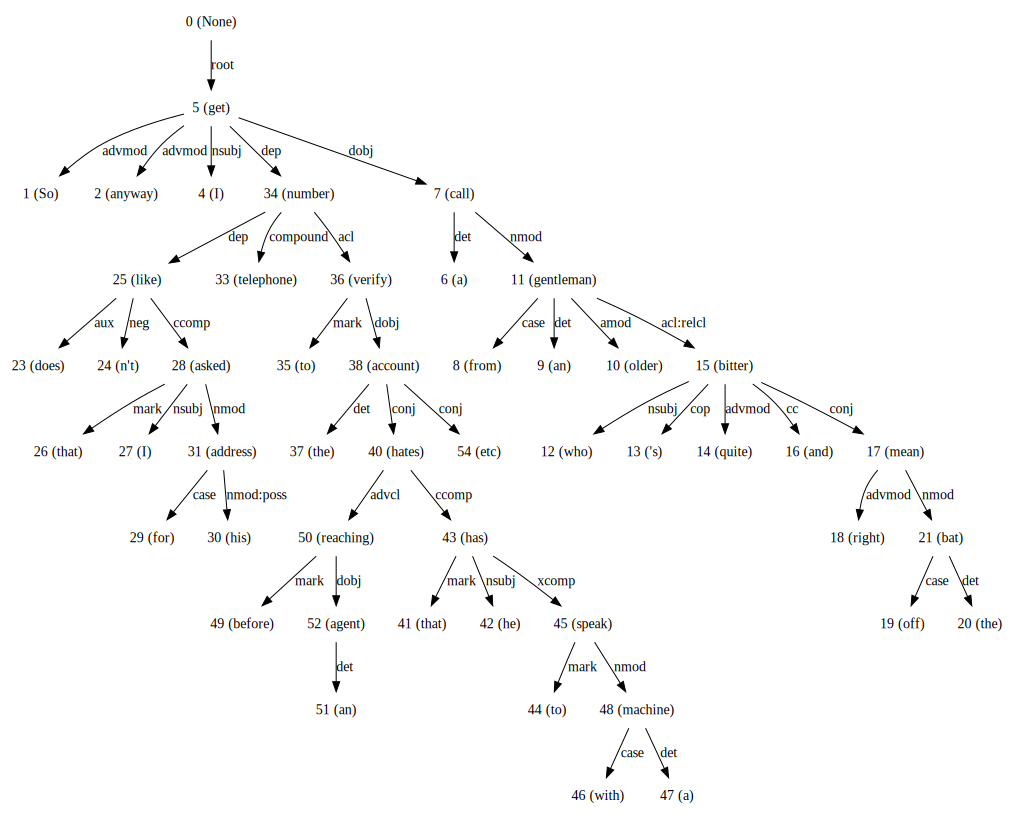

In [209]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

Let's parse the first plot summary in our sample data.

In [238]:
PlotParse = list(stanford.depParser.parse_sents(plots['sentences'][0]))

First let's take a look at the first sentence.

In [244]:
print(' '.join(plots['sentences'][0][0]))

The sacrifice of pig in some ancient ethnic group from the south of Italy , to represent the brutality of human beings rooted in every aspect of our contemporary society .


Then let's parse it and look at the dependency tree.

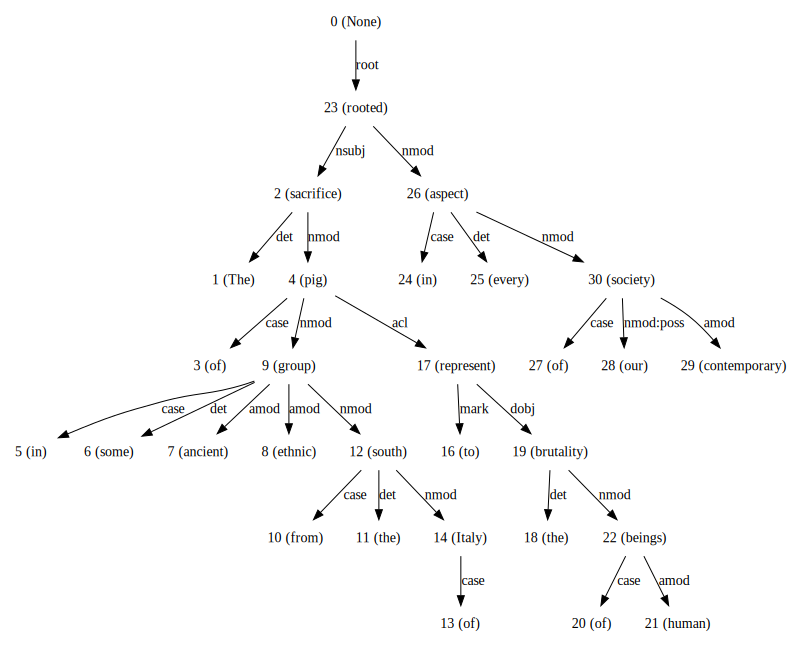

In [245]:
graph = graphviz.Source(list(PlotParse[0])[0].to_dot())
graph

This is a 8-layer tree.

Then let's try the some other sentences.

We see one of the primitive and archaic human behaviour that has driven his struggle for life , the killing of other species .


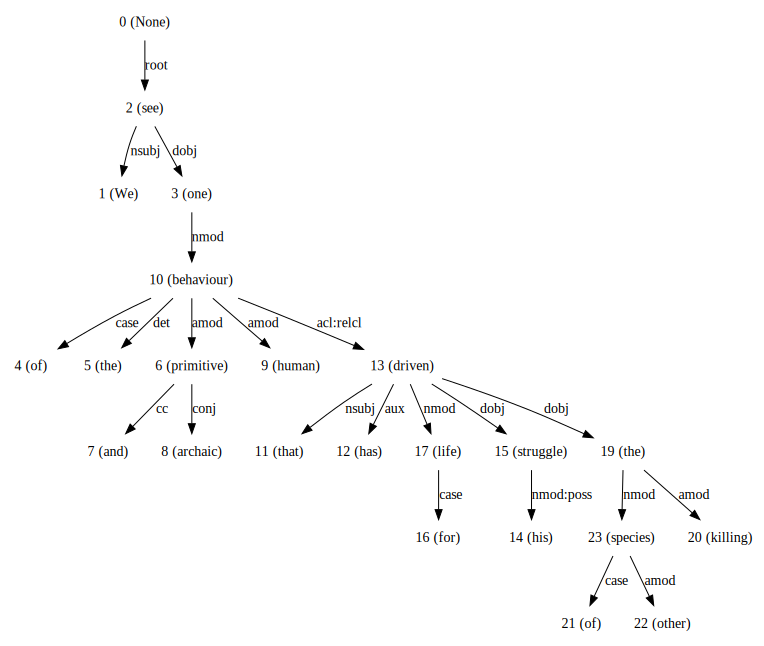

In [247]:
print(' '.join(plots['sentences'][0][1]))
graphviz.Source(list(PlotParse[1])[0].to_dot())

This is also a 8-layer tree.

Everyone at the same time are the executor and the victim of themselves .


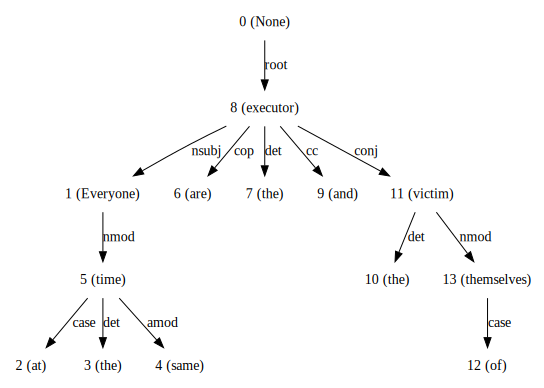

In [248]:
print(' '.join(plots['sentences'][0][2]))
graphviz.Source(list(PlotParse[2])[0].to_dot())

This is a 5-layer tree.

Apparently, the parse depth positively relates to perceived sentence complexity.

From these parses, I can extract nouns collocated in a noun phrase, adjectives that modify a noun, verbs related to a noun, nouns related to an adjective, and adverbs that modify a verb. 
Let's try to parse the whole dataset and capture these sets of things for some words to see what we can find.

In [372]:
PlotsTrees = []
for i in range(len(plots['sentences'])):
    PlotsParses = list(stanford.parser.parse_sents(plots['sentences'][i])) #Converting the iterator to a list so we can call by index. They are still 
    for j in range(len(PlotsParses)):
        PlotSentParseTree = list(PlotsParses[j]) #iterators so be careful about re-running code, without re-running this block
        PlotsTrees += PlotSentParseTree

In [430]:
# A function to find part of speech related to the targets
def find_relation(parsetree, relationType, *targets):
    x = 0
    for i in range(len(parsetree)):
        r = treeRelation(parsetree[i], relationType, *targets)
        if r != []:
            x += 1
            print(i, r)
    if x == 0:
        print('None')

In [458]:
# A function to find part of speech subrelated to the targets
def find_subrelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    x = 0
    for i in range(len(parsetree)):
        r = treeSubRelation(parsetree[i], relationTypeScope, relationTypeTarget, *targets)
        if r != [] and r != set():
            x += 1
            print(i, r)
    if x == 0:
        print('None')

In [460]:
# nouns collocated in a noun phrase
find_relation(PlotsTrees, 'NP', 'world')

16 [[('NP', "the world 's deepest copper mine , where he finds evidence that the Earth 's crust is heating up faster than expected")], [('NP', "the world 's deepest copper mine")], [('NP', "the world 's")]]
23 [[('NP', 'the world')]]
35 [[('NP', 'a world destroyed in a war between man and machine')], [('NP', 'a world')]]
36 [[('NP', 'The world he has awakened in')], [('NP', 'The world')]]
37 [[('NP', '2 who tells him something of what happened to the world')], [('NP', 'something of what happened to the world')], [('NP', 'the world')]]
85 [[('NP', 'a fun ride sure to leave you feeling out of this world')], [('NP', 'this world')]]
102 [[('NP', 'the human fuel to multiply and conquer the world')], [('NP', 'the world')]]
136 [[('NP', 'the world learning about her own humanity and love')], [('NP', 'the world')]]
151 [[('NP', 'a mission on the distant world of Pandora')], [('NP', 'the distant world of Pandora')], [('NP', 'the distant world')]]
178 [[('NP', "A pompous , young inventor who cal

In [461]:
find_subrelation(PlotsTrees, 'NP', 'NN', 'world')

16 {'Earth', 'mine', 'world', 'copper', 'crust', 'evidence'}
23 {'world'}
35 {'war', 'world', 'man', 'machine'}
36 {'world'}
37 {'something', 'world'}
85 {'ride', 'world', 'fun'}
102 {'world', 'fuel'}
136 {'humanity', 'world', 'love'}
151 {'world', 'mission'}
178 {'world', 'man', 'inventor'}
181 {'conflict', 'oil', 'world', 'corporation', 'tribe'}
188 {'one', 'world'}
189 {'world'}
195 {'world', 'way', 'created-or', 'super-prison'}
198 {'world'}


In [464]:
# adjective phrases that modify a noun
find_relation(PlotsTrees, 'ADJP', 'man')

139 [[('ADJP', "Unable to fulfill the grieving man 's expectations , our hero embarks on a journey in search of acceptance , experiencing betrayal and a netherworld of robot gladiators")]]
157 [[('ADJP', 'too much for any man')]]
178 [[('ADJP', 'dead-set on proving that he is the smartest man in the world')]]


In [465]:
find_subrelation(PlotsTrees, 'ADJP', 'JJ', 'man')

139 {'Unable'}
157 {'much'}
178 {'dead-set'}


In [467]:
find_relation(PlotsTrees, 'ADJP', 'woman')

None


In [468]:
# verbs related to a noun
find_relation(PlotsTrees, 'VP', 'he')

12 [[('VP', 'broadcasts dim and distant messages of hope mixed with the music he scavenges from the dead')]]
16 [[('VP', "is led to the world 's deepest copper mine , where he finds evidence that the Earth 's crust is heating up faster than expected")], [('VP', "led to the world 's deepest copper mine , where he finds evidence that the Earth 's crust is heating up faster than expected")]]
18 [[('VP', 'is instead stunned when he learns that the powers-that-be have no intention of publicizing this catastrophe')]]
36 [[('VP', 'learns that he is not alone and that there are others like him , also with a single digit written on their back')]]
43 [[('VP', 'prepares the colony for a guest speaker that he has acquired from the past')]]
46 [[('VP', 'drawn in he')], [('VP', "becomes , especially when he discovers that she 's being hunted by an old foe")]]
71 [[('VP', "lives a horrible life of self-destruction as he is advised by a newly-released device meant to `` better '' it 's user , a Person

In [469]:
find_subrelation(PlotsTrees, 'VP', 'VBZ', 'he')

12 {'scavenges', 'broadcasts'}
16 {'finds', 'is'}
18 {'learns', 'is'}
36 {'learns', 'is'}
43 {'prepares', 'has'}
46 {'becomes', "'s", 'discovers'}
71 {"'s", 'hurts', 'lives', 'begins', 'is'}
84 {'thinks', 'is', 'wakes'}
100 {'has', 'is', 'knows'}
108 {'keeps', 'believes', 'is'}
111 {'jumps', 'is', 'discovers'}
123 {'feels'}
138 {'has', 'is'}
161 {'has', 'is', 'discovers'}
163 {'creates', 'is', 'discovers'}
178 {'is', 'calls'}
179 {'tries', 'is'}
180 {'is'}
185 {'sits'}
186 {"'s", 'talks', 'thinks', 'is'}
189 {'feels', 'does', "'s"}


In [470]:
find_relation(PlotsTrees, 'VP', 'she')

44 [[('VP', "is being chased by forces she does n't quite understand")], [('VP', "being chased by forces she does n't quite understand")], [('VP', "chased by forces she does n't quite understand")]]
46 [[('VP', "becomes , especially when he discovers that she 's being hunted by an old foe")], [('VP', "discovers that she 's being hunted by an old foe")]]
47 [[('VP', 'agrees to help Laurel , who is more than she seems to be')], [('VP', 'to help Laurel , who is more than she seems to be')], [('VP', 'help Laurel , who is more than she seems to be')], [('VP', 'is more than she seems to be')]]
51 [[('VP', 'is immediately attacked by a pack of hungry mutant wolves , which , she easily dispatches with her ancient Old West-style revolvers')], [('VP', 'attacked by a pack of hungry mutant wolves , which , she easily dispatches with her ancient Old West-style revolvers')]]
94 [[('VP', 'looks out her window and is excited to see a shooting star , which she takes as a good sign for her dreams')], [(

In [471]:
find_subrelation(PlotsTrees, 'VP', 'VBZ', 'she')

44 {'does', 'is'}
46 {'becomes', "'s", 'discovers'}
47 {'seems', 'agrees', 'is'}
51 {'dispatches', 'is'}
94 {'looks', 'takes', 'is'}
132 {'has', "'s", 'realizes'}
140 {'is'}
184 {'discovers'}
186 {"'s", 'talks', 'thinks', 'is'}


In [473]:
# nouns related to an adjective
find_relation(PlotsTrees, 'NP', 'beautiful')

19 [[('NP', 'The strong wear weights , the beautiful wear masks and the intelligent wear')], [('NP', 'the beautiful wear masks')]]
93 [[('NP', 'a special night for noted astronomer Ted Lewis , who is preparing a special dinner for his beautiful , adoring wife Lana to celebrate their wedding anniversary')], [('NP', 'noted astronomer Ted Lewis , who is preparing a special dinner for his beautiful , adoring wife Lana to celebrate their wedding anniversary')], [('NP', 'his beautiful , adoring wife Lana to celebrate their wedding anniversary')]]
154 [[('NP', 'the beautiful alien Neytiri')]]


In [474]:
find_subrelation(PlotsTrees, 'NP', 'NN', 'beautiful')

19 {'wear'}
93 {'Lana', 'wife', 'dinner', 'anniversary', 'night', 'wedding', 'astronomer'}


In [476]:
# adverbs that modify a verb
find_relation(PlotsTrees, 'VP', 'save')

34 [[('VP', 'becomes conscious of his divine obligation : to save humanity before it plunges into extinction')], [('VP', 'to save humanity before it plunges into extinction')], [('VP', 'save humanity before it plunges into extinction')]]
106 [[('VP', 'need to a find a way to force the adults to leave the house and discover the vulnerability of the invaders to plot a defense plan to save our planet')], [('VP', 'to a find a way to force the adults to leave the house and discover the vulnerability of the invaders to plot a defense plan to save our planet')], [('VP', 'a find a way to force the adults to leave the house and discover the vulnerability of the invaders to plot a defense plan to save our planet')], [('VP', 'to force the adults to leave the house and discover the vulnerability of the invaders to plot a defense plan to save our planet')], [('VP', 'force the adults to leave the house and discover the vulnerability of the invaders to plot a defense plan to save our planet')], [('VP

In [480]:
find_subrelation(PlotsTrees, 'VP', 'RB', 'save')

None


The dataset I used for this assignment is really small so I would not draw any conclusion here. However, from the above exploration, we can still notice some interesting phenomena that worth to be investigated further. For example, the "world" depicted in this dataset is somehow about "love" and "fun". Even in the sci-fi films, "love" is main topic, so we can see that it is true that "love" is the hardcore of different kinds of literatures and arts. There are more adjectives and verbs to describe man than woman, which may indicate that male characters are taking up larger potion in sci-fi films than woman. The verbs that "he" uses are more meaningful and active than those "she" uses. For instance, "he" "scavenges", "broadcasts", "learns", "prepares", "created", while "she" "thinks", "feels", "seems", and "talks". It might also imply that male characters are more active and important ones in sci-fi movies than female characters.

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [481]:
ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [0.9 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 14.977 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [16.4 sec].
[main] INFO edu.stanford.nlp.pip

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [482]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

In [491]:
ieDF[24:29]

,certainty,subject,verb,object
24,1.0,Martin,was,African
25,1.0,Trayvon Benjamin Martin,was African American from,Florida
26,1.0,Trayvon Benjamin Martin,was American from,Florida
27,1.0,Trayvon Benjamin Martin,was,American
28,1.0,Trayvon Benjamin Martin,was,African American


We can extract the part of Trayvon Martin sentence from `ieDF` as above, and we have found the subject and object, aka compound nouns, that show up with verb phrases, which are "Trayvon Benjamin Martin", "African American", and "was". However, let's look at the sentence again:

In [492]:
text[3]

'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.'

It seems that the dependency parser did not extract the full information from that sentence. Let's try again.

In [494]:
ieDF1 = stanford.openIE(text[3])
ieDF1

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [0.9 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 14.614 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [16.6 sec].
[main] INFO edu.stanford.nlp.pip

,certainty,subject,verb,object
0,1.0,Martin,was,African
1,1.0,Trayvon Benjamin Martin,was African American from,Florida
2,1.0,Trayvon Benjamin Martin,was American from,Florida
3,1.0,Trayvon Benjamin Martin,was,American
4,1.0,Trayvon Benjamin Martin,was,African American


It's still the same and it seems that the parser stops at the second comma of the sentence. Let's try to break the sentence and see if it can do better.

In [502]:
text1 = 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida.'
text2 = 'Trayvon Benjamin Martin, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.'

In [503]:
ieDF2 = stanford.openIE(text1)
ieDF2

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.0 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 13.21 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [15.2 sec].
[main] INFO edu.stanford.nlp.pipe

,certainty,subject,verb,object
0,1.0,Trayvon Benjamin Martin,was American from,Miami Gardens
1,1.0,Trayvon Benjamin Martin,was African American from,Miami Gardens
2,1.0,Trayvon Benjamin Martin,was,African American
3,1.0,Trayvon Benjamin Martin,was,American
4,1.0,Trayvon Benjamin Martin,was American from,Florida
5,1.0,Trayvon Benjamin Martin,was African American from,Florida
6,1.0,Martin,was,African


In [504]:
ieDF3 = stanford.openIE(text2)
ieDF3

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.0 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 14.09 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [16.0 sec].
[main] INFO edu.stanford.nlp.pipe

,certainty,subject,verb,object


It does not perform better even if we break the sentence. It fails on `text2` maybe because it has too many parenthetical phrases. It informs us that it is possible that the dependency parser we use ignores some part of the sentences due to the complexity of them. Therefore, we should carefully choose the parser and examine the performance of it. It might be helpful to compare the results among different versions of parsers and try to break the sentences before being parsed. And we should always be cautious about the machine work just the same as we are about human work.

And we can also look for subject, object, target triples in one of the reddit stories.

In [505]:
ieDF = stanford.openIE(redditTopScores['text'][0])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.0 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 13.428 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [15.0 sec].
[main] INFO edu.stanford.nlp.pip

In [507]:
ieDF[:10]

,certainty,subject,verb,object
0,1.000000,we,'ll get,calls
1,1.000000,we,Quite often 'll get,calls
2,1.000000,we,often 'll get,calls
3,0.831036,we,coax,direct to TV
4,0.774359,straight analog cable,coax,direct from wall
5,0.774359,analog cable,coax,direct from wall to TV
6,0.774359,straight analog cable,coax,direct to TV
7,1.000000,we,would supply analog cable to,homes
8,0.831036,we,coax,direct from wall
9,0.774359,analog cable,coax,direct from wall


In [509]:
len(ieDF)

191

That's almost 200 triples in only:

In [508]:
len(redditTopScores['sentences'][0])

37

sentences and

In [510]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [511]:
ieDF['subject'].value_counts()

I                        48
it                       42
he                       19
He                       18
we                       11
old man                   8
man                       8
call                      4
letter                    4
analog cable              4
straight analog cable     4
our booking calendar      4
my supervisor             3
TV                        2
they                      2
his TV set                2
you                       2
people                    1
repeat offenders          1
our digital equipment     1
handling                  1
our equipment             1
me                        1
Name: subject, dtype: int64

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [513]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

could come                        8
even brought                      5
brought                           5
had                               4
was                               4
speak for                         3
complaint in                      1
have                              1
had cable within                  1
think occasionally about          1
've dealt with                    1
took                              1
still think occasionally about    1
get to                            1
think about                       1
instantly felt                    1
still think about                 1
speak with                        1
get                               1
eventually had                    1
anyway get                        1
felt                              1
ask                               1
do                                1
So anyway get                     1
Name: verb, dtype: int64

and the following objects

In [514]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Mr. Smith                                             4
call                                                  3
him                                                   3
simplified remote                                     2
simplified remote for his set top box                 2
remote                                                2
bad                                                   2
this                                                  2
remote for his set top box                            2
get                                                   2
willing                                               2
speak with her for bit                                1
speak                                                 1
book                                                  1
cable running                                         1
how useless                                           1
speak with her                                        1
experience                                      

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [ ]:
stanford.startCoreServer()

Starting server on http://localhost:16432 , please wait a few seconds


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.

Let's perform  open information extraction on the first plot summary in my dataset.

In [522]:
plot_ieDF = stanford.openIE(plots['plot'][0])
plot_ieDF

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.1 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 14.377 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [16.5 sec].
[main] INFO edu.stanford.nlp.pip

,certainty,subject,verb,object
0,1.0,sacrifice,is in,ancient ethnic group from south of Italy
1,1.0,We,see,killing of other species
2,1.0,We,see,killing of species
3,1.0,We,see,killing
4,1.0,Everyone,are,executor
5,1.0,Everyone,victim of,themselves


Let's take a look at the original text:

In [523]:
plots['plot'][0]

'The sacrifice of pig in some ancient ethnic group from the south of Italy, to represent the brutality of human beings rooted in every aspect of our contemporary society. We see one of the primitive and archaic human behaviour that has driven his struggle for life, the killing of other species. Everyone at the same time are the executor and the victim of themselves.'

In [535]:
print('There are', len(plot_ieDF), 'triples in', len(plots['sentences'][0]), 'sentences and'\
      , sum([len(s) for s in plots['sentences'][0]]), 'words.')

There are 6 triples in 3 sentences and 69 words.


The most common subjects in this plot summary:

In [531]:
plot_ieDF['subject'].value_counts()

We           3
Everyone     2
sacrifice    1
Name: subject, dtype: int64

The most common verbs in this plot summary:

In [532]:
plot_ieDF['verb'].value_counts()

see          3
are          1
victim of    1
is in        1
Name: verb, dtype: int64

The most common objects in this plot summary:

In [533]:
plot_ieDF['object'].value_counts()

executor                                    1
killing                                     1
ancient ethnic group from south of Italy    1
killing of other species                    1
killing of species                          1
themselves                                  1
Name: object, dtype: int64

"We" occures most often with the following verbs:

In [528]:
plot_ieDF[plot_ieDF['subject'] == 'We']['verb'].value_counts()

see    3
Name: verb, dtype: int64

"We" occures most often with the following objects:

In [530]:
plot_ieDF[plot_ieDF['subject'] == 'We']['object'].value_counts()

killing of other species    1
killing                     1
killing of species          1
Name: object, dtype: int64

Apparently there are way too little information been extracted by the open information extraction and many of the information found are repetitive in one or two parts of the triples. It seems that the parser only extracted the very basic and main ideas of a sentence and sacrificed the details. Though it is not a complete extraction of information, it is somehow useful if we only want the most basic information, for example, if we just want information about "who do what" with each component being consist of one word, we can make use of the open information extraction as follows.

In [540]:
plot_ieDF['subject_len'] = plot_ieDF['subject'].str.split().str.len()
plot_ieDF['verb_len'] = plot_ieDF['verb'].str.split().str.len()
plot_ieDF['object_len'] = plot_ieDF['object'].str.split().str.len()
plot_ieDF

,certainty,subject,verb,object,subject_len,verb_len,object_len
0,1.0,sacrifice,is in,ancient ethnic group from south of Italy,1,2,7
1,1.0,We,see,killing of other species,1,1,4
2,1.0,We,see,killing of species,1,1,3
3,1.0,We,see,killing,1,1,1
4,1.0,Everyone,are,executor,1,1,1
5,1.0,Everyone,victim of,themselves,1,2,1


In [549]:
main_statement = plot_ieDF.loc[(plot_ieDF['subject_len'] == 1) & (plot_ieDF['verb_len'] == 1) & (plot_ieDF['object_len'] == 1)]
main_statement

,certainty,subject,verb,object,subject_len,verb_len,object_len
3,1.0,We,see,killing,1,1,1
4,1.0,Everyone,are,executor,1,1,1
